
<font size="4"> <p style="text-align: center;">Written by Spicer Bak, July 2023  </p> </font>  

<font size="4"> **Yellowfin Autonomous surface vehicle (ASV) python post processing**  </font>  


Data are to be located in relative path as below and organized as follows

`datadir = [some]/[path]/[location]`   
this is typically `datadir = [some]/[path]/[YYYYmmdd]`  where the `YYYYmmdd` is the date of the yellowfin survey 
for this example we'll use the path `datadir = /data/yellowfin/20230327`


The workflow is as follows: 
1. **Download Base station data from CORS and post process**
     - RINEX data come frome the emlid post-processor in zip files.  for the purposes of this post-processing example these data are unzipped in the `datadir`
         - `/data/yellowfin/20230327/YF2Reachm2_raw_[......]_RINEX_[....]`
         - inside this folder is assumed to be `*.XXB`, `*.XXP`, `*.XXO` and most importantly the `*.pos` files which are the ppk processed output files
2. **Define data files and paths**  
3. **Define a python library of functions from which to call.  In my workflow i call this `yellowfinlib`. in the below the functions are simply defined and called by name.**  
4. **Load and process sonar data to *.h5 data:**
     - s500 data are assumed to be in a `s500` subfolder within the `datadir`
         - `/data/yellowfin/20230327/s500`
         - inside this folder are assumed `*.dat` files
5. **Load and process `*.pos` files, save `*.h5` file**  
6. **Merge Sonar and PPK data**  



##  1. Download Base station data from CORS and post-process Kinematic
Before processing any of the below, we're going to go through the steps to produce the Post Processing Kinematic  the PPK files, we need to make sure that we generate the proper `*.pos` file from the emlid studio. 

The emlid stuido software is here: https://docs.emlid.com/emlid-studio/

To perform post-processing, you will need the following files:

   - a RINEX observation file from a base
       - These data are available here: https://geodesy.noaa.gov/UFCORS/  
       - for the rest of this we will assume use of the Duck CORS station
   - a RINEX observation file from a rover (provided in the RINEX folders)
   - a RINEX navigation file from a base or from a rover (provided in the RINEX folder) 

### 1. download CORS Data:
filled out for Duck on example data used for this effort.  Make sure to ensure the `duration in hours` encompassses the operation time of the yellowfin. I typically download the whole 24 hours on the day of operation.
![image](supportingFiles/CORS.png) 

### 2. open Emlid Studio and load files 
load rover file in top and bottom, and base `*.XXo` into the middle field

![image](supportingFiles/ppk1.png)

Data show path of rover (yellowfin ASV).  notice the colors identify type of fix.  Green is "fixed" and yellow is "float"

![image](supportingFiles/ppk2.png)


This will produce `*.pos` files for each of the Navigation (`*.XXp`) and Observation (`*.XXo`) file pairs.  The Base file will stay the same and needs to be co-timed to that of the Nav/Obs files.

**Note Antenna Height is not adjusted here it is adjusted later in the workflow**


## 2. Define data files and paths

In [1]:
import os
import matplotlib
matplotlib.use('TkAgg')
# %matplotlib notebook / widgit
%matplotlib inline
# establish data location paths to be used for the rest of the code base
database = "/data/yellowfin/" #"../SampleData"
timeString = "20230417" # "20230327"
datadir = os.path.join(database,timeString)
plotDir = os.path.join(datadir,'figures')
os.makedirs(plotDir, exist_ok=True)  # make folder structure if its not already made
# sonar data 
fpathSonar = os.path.join(datadir, 's500') # reads sonar from here
saveFnameSonar = os.path.join(datadir, f'{timeString}_sonarRaw.h5') #saves sonar file here

#NMEA data from sonar, this is not Post Processed Kinematic (PPK) data.  It is used for only cursory or 
# introductory look at the data 
fpathGNSS = os.path.join(datadir, 'nmeaData')  # load NMEA data from this location
saveFnameGNSS = os.path.join(datadir, f'{timeString}_gnssRaw.h5')  # save nmea data to this location

# RINEX data 
# look for all subfolders with RINEX in the folder name inside the "datadir" emlid ppk processor 
saveFnamePPK = os.path.join(datadir, f'{timeString}_ppkRaw.h5')


## 3. Define Yellowfinlib
The below functions are simply defined and called, but for typical workflows (out of jupyter notebook, this would be put into it's own `yellowfinlib.py` and be called `import yellowfinlib` where each function would be executed as `yellowfinlib.read_emlid_pos(arg1, arg2)`

In [2]:
import os
import struct
import datetime as DT
import h5py
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tqdm
from matplotlib import pyplot as plt



def read_emlid_pos(fldrlistPPK, plot=False, saveFname=None):
    """read and parse multiple pos files in multiple folders provided
    
    :param fldrlistPPK: list of folders to provide
    :param plot: if a path name will save a QA/QC plots (default=False)
    :param saveFname: will save file as h5
    :return: dataframe with loaded data from pos file
    """
    T_ppk = pd.DataFrame()
    for fldr in sorted(fldrlistPPK):
        # this is before ppk processing so should agree with nmea strings
        fn = glob.glob(os.path.join(fldr, "*.pos"))[0]
        try:
            colNames = ['datetime', 'lat', 'lon', 'height', 'Q', 'ns', 'sdn(m)',  'sde(m)', 'sdu(m)',
                        'sdne(m)', 'sdeu(m)',  'sdun(m)', 'age(s)',  'ratio']
            Tpos = pd.read_csv(fn, delimiter=r'\s+ ', header=10, names=colNames, engine='python')
            print(f'loaded {fn}')
            if all(Tpos.iloc[-1]):  #if theres nan's in the last row
                Tpos = Tpos.iloc[:-1] # remove last row
            T_ppk = pd.concat([T_ppk, Tpos]) # merge multiple files to single dataframe
        
        except:
            continue
    T_ppk['datetime'] = pd.to_datetime(T_ppk['datetime'], format='%Y/%m/%d %H:%M:%S.%f', utc=True)
    
    # now make plot of both files
    # first llh file
    # plt.plot(T_LLH['lon'], T_LLH['lat'], '.-m', label = 'LLH file')
    # plt.xlabel('longitude')
    # plt.ylabel('latitude')
    if plot is not False:
        plt.plot(T_ppk['lon'], T_ppk['lat'], '.-g', label = 'PPK file')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.legend()
        plt.tight_layout()
        plt.savefig(plot+'Lat_Lon')
        plt.close()
        
        fig = plt.figure()
        plt.plot(T_ppk['datetime'], T_ppk['height'], label='elevation')
        plt.plot(T_ppk['datetime'], 10 * T_ppk['Q'], '.', label='quality factor')
        plt.plot(T_ppk['datetime'], 10000 * (T_ppk['lat'] - T_ppk['lat'].iloc[0]), label='lat from original lat')
        plt.xlabel('time')
        plt.legend()
        plt.tight_layout()
        plt.savefig(plot+'elev_Q')
        plt.close()
    
    return T_ppk


def loadSonar_s500_binary(dataPath, outfname=None, verbose=False):
    """Loads and concatenates all of the binary files (*.dat) located in the dataPath location
    
    :param dataPath: search path for sonar data files
    :param outfname: string to save h5 file. If None it will skip this process. (Default =None)
    :param verbose: turn on print statement for file names as loading
    :return: pandas data frame of sonar data
    """
    dd = glob.glob(os.path.join(dataPath, "*.dat"))  # find dat files for sonar
    print(f'found {len(dd)} sonar files for processing')  # loop through files
    # https://docs.ceruleansonar.com/c/v/s-500-sounder/appendix-f-programming-api
    ij, i3 = 0, 0
    allocateSize = 50000  # some rediculously large number that memory can still hold.
    # initialize variables for loop
    distance, confidence, transmit_duration = np.zeros(allocateSize), np.zeros(allocateSize), np.zeros(
        allocateSize)  # [],
    ping_number, scan_start, scan_length = np.zeros(allocateSize), np.zeros(allocateSize), np.zeros(allocateSize)
    end_ping_hz, adc_sample_hz, timestamp_msec, spare2 = np.zeros(allocateSize), np.zeros(allocateSize), \
                                                         np.zeros(allocateSize), np.zeros(allocateSize)
    start_mm, length_mm, start_ping_hz = np.zeros(allocateSize), np.zeros(allocateSize), np.zeros(allocateSize),
    ping_duration_sec, analog_gain, profile_data_length, = np.zeros(allocateSize), np.zeros(allocateSize), np.zeros(
        allocateSize)
    
    min_pwr, step_db, smooth_depth_m, fspare2 = np.zeros(allocateSize), np.zeros(allocateSize), \
                                                np.zeros(allocateSize), np.zeros(allocateSize)
    is_db, gain_index, power_results = np.zeros(allocateSize), np.zeros(allocateSize), np.zeros(allocateSize)
    max_pwr, num_results = np.zeros(allocateSize), np.zeros(allocateSize, dtype=int)
    gain_setting, decimation, reserved = np.zeros(allocateSize), np.zeros(allocateSize), np.zeros(allocateSize),
    # these are complicated preallocations
    txt, dt_profile, dt_txt, dt = np.zeros(allocateSize, dtype=object), np.zeros(allocateSize, dtype=object), \
                                  np.zeros(allocateSize, dtype=object), np.zeros(allocateSize, dtype=object)
    rangev = np.zeros((allocateSize*2, allocateSize)) #arbitrary large value for time
    profile_data = np.zeros((allocateSize*2, allocateSize))
    
    for fi in tqdm.tqdm(range(len(dd))):
        with open(dd[fi], 'rb') as fid:
            fname = dd[fi]
            if verbose: print(f'processing {fname}')
            xx = fid.read()
            st = [i + 1 for i in range(len(xx)) if xx[i:i + 2] == b'BR']
            # initalize variables for loop
            packet_len, packet_id = np.zeros(len(st)), np.zeros(len(st))
            for ii in range(len(st) - 1):
                fid.seek(st[ii] + 1, os.SEEK_SET)
                datestring = fid.read(26).decode('utf-8',
                                                 'replace')  # 'replace' causes a replacement marker (such as '?')
                # to be inserted where there is malformed data.
                try:
                    dt[ii] = DT.datetime.strptime(datestring, '%Y-%m-%d %H:%M:%S.%f')
                except:
                    continue
                packet_len[ii] = struct.unpack('<H', fid.read(2))[0]
                packet_id[ii] = struct.unpack('<H', fid.read(2))[0]
                r1 = struct.unpack('<B', fid.read(1))[0]
                r2 = struct.unpack('<B', fid.read(1))[0]
                if packet_id[ii] == 1300: # these are i believe ping sonar values
                    distance[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    confidence[ij] = struct.unpack('<H', fid.read(2))[0]  # mm
                    transmit_duration[ij] = struct.unpack('<H', fid.read(2))[0]  # us
                    ping_number[ij] = struct.unpack('<I', fid.read(4))[0]  # #
                    scan_start[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    scan_length[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    gain_setting[ij] = struct.unpack('<I', fid.read(4))[0]
                    profile_data_length[ij] = struct.unpack('<I', fid.read(4))[0]
                    for jj in range(200):
                        tmp = struct.unpack('<B', fid.read(1))[0]
                        if tmp:
                            profile_data[ij, jj] = tmp
                    ij += 1
                
                if packet_id[ii] == 3:
                    txt[ij] = fid.read(int(packet_len[ii])).decode('utf-8')
                    dt_txt[ij] = dt
                if packet_id[ii] == 1308: # these are s500 protocols
                    dtp = dt
                    # https://docs.ceruleansonar.com/c/v/s-500-sounder/appendix-f-programming-api#ping-response-packets
                    ping_number[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    start_mm[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    length_mm[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    start_ping_hz[ij] = struct.unpack('<I', fid.read(4))[0]  # us
                    end_ping_hz[ij] = struct.unpack('<I', fid.read(4))[0]  # #
                    adc_sample_hz[ij] = struct.unpack('<I', fid.read(4))[0]  # mm
                    timestamp_msec[ij] = struct.unpack('I', fid.read(4))[0]
                    spare2[ij] = struct.unpack('I', fid.read(4))[0]
                    
                    ping_duration_sec[ij] = struct.unpack('f', fid.read(4))[0]
                    analog_gain[ij] = struct.unpack('f', fid.read(4))[0]
                    max_pwr[ij] = struct.unpack('f', fid.read(4))[0]
                    min_pwr[ij] = struct.unpack('f', fid.read(4))[0]
                    step_db[ij] = struct.unpack('f', fid.read(4))[0]
                    smooth_depth_m[ij] = struct.unpack('f', fid.read(4))[0]
                    fspare2[ij] = struct.unpack('f', fid.read(4))[0]
                    
                    is_db[ij] = struct.unpack('B', fid.read(1))[0]
                    gain_index[ij] = struct.unpack('B', fid.read(1))[0]
                    decimation[ij] = struct.unpack('B', fid.read(1))[0]
                    reserved[ij] = struct.unpack('B', fid.read(1))[0]
                    num_results[ij] = struct.unpack('H', fid.read(2))[0]
                    power_results[ij] = struct.unpack('H', fid.read(2))[0]
                    rangev[ij, 0:num_results[ij]] = np.linspace(start_mm[ij], start_mm[ij] + length_mm[ij],
                                                                num_results[ij])
                    dt_profile[ij] = dt[ii]  # assign datetime from data written
                    # profile_data_single = [] #= np.empty((num_results[-1], ), dtype=np.uint16)
                    for jj in range(num_results[ij]):
                        # print(jj)
                        read = fid.read(2)
                        if read:
                            try:  # data should be unsigned short
                                tmp = struct.unpack('<H', read)[0]
                            except:  # when it's unsigned character
                                tmp = struct.unpack('B', read)[0]
                            if tmp:
                                profile_data[ij, jj] = tmp
                    ij += 1
    
    # clean up array's from over allocation to free up memory and data
    idxShort = (num_results != 0 ).sum() #np.argwhere(num_results != 0).max()  # identify index for end of data to keep
    num_results = np.median(num_results[:idxShort]).astype(int) #num_results[:idxShort][0]

    # make data frame for output
    
    smooth_depth_m = smooth_depth_m[:idxShort]
    reserved = reserved[:idxShort]
    start_mm = start_mm[:idxShort]
    length_mm = length_mm[:idxShort]
    start_ping_hz = start_ping_hz[:idxShort]
    end_ping_hz = end_ping_hz[:idxShort]
    adc_sample_hz = adc_sample_hz[:idxShort]
    timestamp_msec = timestamp_msec[:idxShort]
    spare2 = spare2[:idxShort]
    ping_duration_sec = ping_duration_sec[:idxShort]
    analog_gain = analog_gain[:idxShort]
    max_pwr = max_pwr[:idxShort]
    min_pwr = min_pwr[:idxShort]
    step_db = step_db[:idxShort]
    fspare2 = fspare2[:idxShort]
    is_db = is_db[:idxShort]
    gain_index = gain_index[:idxShort]
    decimation = decimation[:idxShort]
    dt_profile = dt_profile[:idxShort]
    
    # rangev,  profile_data need to be handled separately
    rangev = rangev[0, :num_results]
    profile_data = profile_data[:idxShort, :num_results].T
    
    # now save output file (can't save as pandas because of multi-dimensional sonar data)
    if outfname is not None:
        with h5py.File(outfname, 'w') as hf:
            hf.create_dataset('min_pwr', data=min_pwr)
            hf.create_dataset('ping_duration', data=ping_duration_sec)
            hf.create_dataset('time', data=nc.date2num(dt_profile, 'seconds since 1970-01-01')) # TODO: confirm tz
            hf.create_dataset('smooth_depth_m', data=smooth_depth_m)
            hf.create_dataset('profile_data', data=profile_data)  # putting time as first axis
            hf.create_dataset('num_results', data=num_results)
            hf.create_dataset('start_mm', data=start_mm)
            hf.create_dataset('length_mm', data=length_mm)
            hf.create_dataset('start_ping_hz', data=start_ping_hz)
            hf.create_dataset('end_ping_hz', data=end_ping_hz)
            hf.create_dataset('adc_sample_hz', data=adc_sample_hz)
            hf.create_dataset('timestamp_msec', data=timestamp_msec)
            hf.create_dataset('analog_gain', data=analog_gain)
            hf.create_dataset('max_pwr', data=max_pwr)
            hf.create_dataset('this_ping_depth_m', data=step_db)
            hf.create_dataset('this_ping_depth_measurement_confidence', data=is_db)
            hf.create_dataset('smoothed_depth_measurement_confidence', data=reserved)
            hf.create_dataset('gain_index', data=gain_index)
            hf.create_dataset('decimation', data=decimation)
            hf.create_dataset('range_m', data=rangev / 1000)
    

def load_h5_to_dictionary(fname):
    """Loads already created H5 file from the sonar data. """
    hf = h5py.File(fname, 'r')
    dataOut = {}
    for key in hf.keys():
        dataOut[key] = np.array(hf.get(key))
    return dataOut


def plot_single_backscatterProfile(fname, time, sonarRange, profile_data, this_ping_depth_m, smooth_depth_m, index):
    """Create's a plot that shows full backscatter and individual profile  with identified depths
    
    :param fname:
    :param time:
    :param sonarRange:
    :param profile_data:
    :param this_ping_depth_m:
    :param smooth_depth_m:
    :param index:
    :return:
    """
    plt.figure(figsize=(12, 8))
    ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=3, rowspan=4)
    backscatter = ax1.pcolormesh(time, sonarRange[0], profile_data.T, shading='auto')
    ax1.plot(time, this_ping_depth_m, color='black', ms=0.1, label='instant depth', alpha=0.5)
    # ax1.plot(time, smooth_depth_m, 'black', ms=1, label='Smooth Depth')
    ax1.plot(time[index], smooth_depth_m[index], ms=15, marker='X', color='red')
    cbar = plt.colorbar(mappable=backscatter, ax=ax1)
    cbar.set_label('backscatter value')
    ax1.set_ylim([0, 5])
    
    ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=4, sharey=ax1)
    ax2.plot(profile_data[index], sonarRange[0], alpha=1)
    ax2.plot(profile_data[index, np.argmin(np.abs(sonarRange[index] - this_ping_depth_m[index]))], this_ping_depth_m[
        index], 'grey', marker='X', ms=10, label='this ping')
    ax2.plot(profile_data[index, np.argmin(np.abs(sonarRange[index] - smooth_depth_m[index]))], smooth_depth_m[index],
             'black', marker='X', ms=10, label='smoothed bottom')
    ax2.legend()
    
    for ii in range(5):
        ax2.plot(profile_data[index - ii], sonarRange[0], alpha=.4 - ii * .07, color='k')
    ax2.set_ylabel('depth [m]')
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()


def mLabDatetime_to_epoch(dt):
    """Convert matlab datetime to unix Epoch time"""
    epoch = DT.datetime(1970, 1, 1)
    delta = dt - epoch
    return delta.total_seconds()

def convertEllipsoid2NAVD88(lats, lons, ellipsoids, geoidFile='g2012bu8.bin'):
    """converts elipsoid values to NAVD88's
   
   NOTE: if this is the first time you're using this, you'll likely have to go get the geoid bin file.  Code was
        developed using the uncompressed bin file.  It is unclear if the pygeodesy library requires the bin file to
        be uncompressed.  https://geodesy.noaa.gov/GEOID/GEOID12B/GEOID12B_CONUS.shtml
  
  :param lats:
  :param lons:
  :param ellipsoids: raw sattelite elipsoid values.
  :param geoidFile: pull from https://geodesy.noaa.gov/GEOID/GEOID12B/GEOID12B_CONUS.shtml
  :return: NAVD88 values
  """
    from pygeodesy import geoids
    assert len(lons) == len(lats) == len(ellipsoids), 'lons/lats/elipsoids need to be of same length'
    try:
        instance = geoids.GeoidG2012B(geoidFile)
    except ImportError:
        print("if this is the first time you're using this, you'll likely have to go get the geoid bin file.  Code was "
              "developed using the uncompressed bin file.  It is unclear if the pygeodesy library requires the bin file to"
              " be uncompressed.  https://geodesy.noaa.gov/GEOID/GEOID12B/GEOID12B_CONUS.shtml")
        import wget
        wget.download("https://www.ngs.noaa.gov/PC_PROD/GEOID12B/Format_unix/g2012bu0.bin")
    geoidHeight = instance.height(lats, lons)
    return ellipsoids - geoidHeight

def load_yellowfin_NMEA_files(fpath, saveFname, plotfname=False, verbose=False):
    """loads and possibly plots NMEA data from Emlid Reach M2 on yellowin
    
    :param fpath: location to search for NMEA data files
    :param saveFname: where to save the Hdf5 file
    :param plotfname: where to save plot showing path of yellowfin, if False, will not plot (default=False)
    :param verbose: will print more output when processing if True (default=False)
    :return:
    """
    dd = glob.glob(os.path.join(fpath, '*.dat'))
    if verbose: print(f'processing {len(dd)} GPS data files')
    
    ji = 0
    gps_time, lat, lon, altWGS84, altMSL, pc_time_gga = [], [], [], [], [], []
    lat, latHemi, lon, lonHemi, fixQuality, satCount, HDOP = [], [], [], [], [], [], []
    elevationMSL, eleUnits, geoSep, geoSepUnits, ageDiffGPS, diffRefStation = [], [], [], [], [], []
    for fi in tqdm.tqdm(range(1, len(dd))):
        fname = dd[fi]
        
        if verbose: print(fname)

        with open(fname, 'r') as f:
            lns = f.readlines()
        
        for ln in lns:
            if ln.strip():
                try:
                    ss = ln.split('$')
                    datestring = ss[0].strip('#')
                    stringNMEA = ss[1].split(',')
                except IndexError:
                    continue
                
                dt = DT.datetime.strptime(datestring, '%Y-%m-%d %H:%M:%S.%f')
                nmcode = stringNMEA[0]

                if nmcode == 'GNGGA' and len(stringNMEA[2]) > 1:
                    # Sentence Identifier: This field identifies the type of NMEA sentence and is represented by "$GPGGA" for the GGA sentence.
                    # 1. UTC Time: This field provides the time in hours, minutes, and seconds in UTC.
                    # 2. Latitude: This field represents the latitude of the GPS fix in degrees and minutes, in the format of
                    #     ddmm.mmmm, where dd denotes degrees and mm.mmmm denotes minutes.
                    # 3. Latitude Hemisphere: This field indicates the hemisphere of the latitude, either "N" for North or "S" for South.
                    # 4. Longitude: This field represents the longitude of the GPS fix in degrees and minutes, in the format
                    # of dddmm.mmmm, where ddd denotes degrees and mm.mmmm denotes minutes.
                    # 5. Longitude Hemisphere: This field indicates the hemisphere of the longitude, either "E" for East or "W" for West.
                    # 6. GPS Fix Quality: This field provides information about the quality of the GPS fix, represented by a
                    # numeric value. Common values include 0 for no fix, 1 for GPS fix, and 2 for Differential GPS (DGPS) fix.
                    # 7. Number of Satellites in Use: This field indicates the number of satellites used in the GPS fix represented by a numeric value.
                    # 8. Horizontal Dilution of Precision (HDOP): This field represents the HDOP, which is a measure of the
                    # horizontal accuracy of the GPS fix, represented by a numeric value.
                    # 9 Altitude: This field provides the altitude above mean sea level (MSL) in meters, represented by a numeric value.
                    # 10 Altitude Units: This field indicates the units used for altitude, typically "M" for meters.
                    # 11 Geoidal Separation: This field represents the geoidal separation, which is the difference between
                    # the WGS84 ellipsoid and mean sea level, in meters, represented by a numeric value.
                    # 12Geoidal Separation Units: This field indicates the units used for geoidal separation, typically "M" for meters.
                    # 13 Age of Differential GPS Data: This field provides the age of the DGPS data used in the GPS fix, represented by a numeric value.
                    # 14 Differential Reference Station ID: This field indicates the identification number of the DGPS
                    # reference station used in the GPS fix, represented by a numeric value.
                    #
                    # parse the individual string, add to list
                    pc_time_gga.append(dt)
                    gps_time.append(float(stringNMEA[1]))
                    lat.append(float(stringNMEA[2][:2]) + float(stringNMEA[2][2:]) / 60)
                    latHemi.append(stringNMEA[3])
                    lona = float(stringNMEA[4][:3]) + float(stringNMEA[4][2:]) / 60
                    lonHemi.append(stringNMEA[5])
                    if lonHemi == 'W': lona = -lona
                    lon.append(lona)
                    fixQuality.append(
                            int(stringNMEA[6]))  # GPS Fix Quality: represented by anumeric value. Common values
                    # include 0 for no fix, 1 for GPS fix, and 2 for Differential GPS (DGPS) fix.
                    satCount.append(int(stringNMEA[7]))
                    HDOP.append(float(stringNMEA[8]))  # measure of the horizontal accuracy of the GPS fix, represented
                    # by a numeric value.
                    altMSL.append(float(stringNMEA[9]))
                    eleUnits.append(stringNMEA[10])
                    geoSep.append(float(stringNMEA[11]))
                    geoSepUnits.append(stringNMEA[12])
                    ageDiffGPS.append(float(stringNMEA[13]))
                    diffRefStation.append(stringNMEA[14].strip())

    lat = np.array(lat)
    lon = np.array(lon)
    lat[lat == 0] = np.nan
    lon[lon == 0] = np.nan
    # convert datetimes to epochs for file writing.
    gpstimeobjs = [DT.time(int(str(ii)[:2]), int(str(ii)[2:4]), int(str(ii)[4:6]), int(str(ii)[7:] + '00000')) for ii in
                   gps_time]
    aa = [DT.datetime.combine(pc_time_gga[ii].date(), gpstimeobjs[ii]) for ii in range(len(gpstimeobjs))]
    # now save output file
    with h5py.File(saveFname, 'w') as hf:
        hf.create_dataset('lat', data=lat)
        # hf.create_dataset('latHemi', data=latHemi)
        hf.create_dataset('lon', data=lon)
        # hf.create_dataset('lonHemi',data=lonHemi)
        hf.create_dataset('fixQuality', data=fixQuality)
        hf.create_dataset('satCount', data=satCount)
        hf.create_dataset('HDOP', data=HDOP)
        hf.create_dataset('pc_time_gga', data=[mLabDatetime_to_epoch(pc_time_gga[ii]) for ii in range(len(pc_time_gga))])
        hf.create_dataset('gps_time', data=[mLabDatetime_to_epoch(aa[i]) for i in range(len(aa))])
        hf.create_dataset('altMSL', data=altMSL)
        # hf.create_dataset('eleUnits', data=eleUnits) # putting time as first axis
        # hf.create_dataset('geoSepUnits', data=geoSepUnits)
        hf.create_dataset('ageDiffGPS', data=ageDiffGPS)
    # now plot data
    if plotfname is not False:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.plot(lon, lat, '-')
        plt.subplot(122)
        # plt.plot(pc_time_gga, altWGS84, '.-')
        # plt.plot(pc_time_gga, geoSep, label='geoSep')
        plt.plot(pc_time_gga, altMSL, '.-', label='altMSL')
        plt.savefig(plotfname)
        plt.close()


def findTimeShiftCrossCorr(signal1, signal2, sampleFreq=1):
    """  Finds time shift between two signals.
    
    :param signal1: a signal of same length of signal 2
    :param signal2: a signal of same length of signal 1
    :param sampleFreq: sampling frequency, in HZ
    :return: phase lag in samples, phase lag in time
    """
    import numpy as np
    from scipy.signal import correlate
    assert len(signal1) == len(signal2), 'signals need to be the same lenth'
    # load your time series data into two separate arrays, let's call them signal1 and signal2.
    # compute the cross-correlation between the two signals using the correlate function:
    cross_corr = correlate(signal1, signal2)
    # Identify the index of the maximum value in the cross-correlation:
    max_index = np.argmax(np.abs(cross_corr))
    # Compute the phase lag in terms of the sample offset:
    phase_lag_samples = max_index - (len(signal1) - 1)
    # # If desired, convert the phase lag to time units (e.g., seconds):
    phase_lag_seconds = phase_lag_samples * sampleFreq
    return phase_lag_samples, phase_lag_seconds


def loadLLHfiles(flderlistLLH):
    # first load the LLH quick processed data
    T_LLH = pd.DataFrame()
    for fldr in sorted(flderlistLLH):
        # this is before ppk processing so should agree with nmea strings
        fn = glob.glob(os.path.join(fldr, "*"))[0]
        try:
            T = pd.read_csv(fn, delimiter='  ', header=None, engine='python')
            print(f'loaded {fn}')
            if all(T.iloc[-1]):  #if theres nan's in the last row
                T = T.iloc[:-1] # remove last row
            T_LLH = pd.concat([T_LLH, T]) # merge multiple files to single dataframe
        
        except:
            continue
    
    T_LLH['datetime'] = pd.to_datetime(T_LLH[0], format='%Y/%m/%d %H:%M:%S.%f', utc=True)
    T_LLH['epochTime'] = T_LLH['datetime'].apply(lambda x: x.timestamp())

    T_LLH['lat'] =  T_LLH[1]
    T_LLH['lon'] = T_LLH[2]
    return T_LLH


def loadPPKdata(fldrlistPPK):
    """This function loads multiple *.pos files that are output from the emlid post processing software.  it will
    combine pos files that are in individual folders
    
    :param fldrlistPPK: a list of folders with ind
    :return: a data frame with loaded ppk data
    """
    
    T_ppk = pd.DataFrame()
    for fldr in sorted(fldrlistPPK):
        # this is before ppk processing so should agree with nmea strings
        fn = glob.glob(os.path.join(fldr, "*.pos"))
        assert len(fn) > 1, " This function assumes only one pos file per folder, please check"
        fn = fn[np.argwhere(['events' not in f for f in fn]).squeeze()] # take the file that is not events
        try:
            colNames = ['datetime', 'lat', 'lon', 'height', 'Q', 'ns', 'sdn(m)',  'sde(m)', 'sdu(m)', \
                        'sdne(m)', 'sdeu(m)',  'sdun(m)', 'age(s)',  'ratio']
            Tpos = pd.read_csv(fn, delimiter=r'\s+ ', header=10, names=colNames, engine='python')
            print(f'loaded {fn}')
            if all(Tpos.iloc[-1]):  #if theres nan's in the last row
                Tpos = Tpos.iloc[:-1] # remove last row
            Tpos['datetime'] = pd.to_datetime(Tpos['datetime'], format='%Y/%m/%d %H:%M:%S.%f', utc=True)
            T_ppk = pd.concat([T_ppk, Tpos], ignore_index=True) # merge multiple files to single dataframe
            
        except:  # this is in the event there is no data in the pos files
            continue
    T_ppk['datetime'] = pd.to_datetime(T_ppk['datetime'], format='%Y/%m/%d %H:%M:%S.%f', utc=True)
    T_ppk['epochTime'] = T_ppk['datetime'].apply(lambda x: x.timestamp())
    return T_ppk



# load files 
## 4. Start loading the sonar files

In [3]:
#First load Sonar Data: this loads all of the *.dat files and saves a h5 file
print(fpathSonar)
loadSonar_s500_binary(fpathSonar, outfname=saveFnameSonar, verbose=False) 

  0%|          | 0/49 [00:00<?, ?it/s]

/data/yellowfin/20230417/s500
found 49 sonar files for processing


100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


## load NMEA files that are logged on rasberry pi

In [4]:
# then load NMEA files 
load_yellowfin_NMEA_files(fpathGNSS, saveFname=saveFnameGNSS,
                          plotfname=os.path.join(datadir, 'figures', 'GPSpath.png'))
#note these files are only used for time syncing the GNSS data

100%|██████████| 3161/3161 [00:02<00:00, 1267.02it/s]


## 5. load Post processing Kinematic (PPK) files

In [5]:
# now load ppk files 
# first find all the folders that have ppk data in them
fldrlistPPK = [] # initalize list for appending RINEX folder in
[fldrlistPPK.append(os.path.join(datadir, fname)) for fname in os.listdir(datadir) if 'RINEX' in fname and '.zip' not in fname]
T_ppk = loadPPKdata(fldrlistPPK)
T_ppk.to_hdf(saveFnamePPK, 'ppk') # now save the h5 intermediate file 

loaded /data/yellowfin/20230417/YF2Reachm2_raw_20230417175614_RINEX_3_03/YF2Reachm2_raw_20230417175614.pos


## 6. Now Merge the PPK and Sonar Data

 **important Note:  This script assumes the pi computer is in EST** 
 1. shift Eastern Time zone to UTC.  This this is handled with a rigid shift between da hour timeshift to UTC. This is approimated by using 2023 daylight windows where Mar 12 is the 71 day of the year and Nov 5 is the 309 day of th year. To avoid this in the future, we've shifted our vehicle's pi to UTC so as to avoid this shifting in the future.
 2. load all of the data, shift GNSS by leap second and convert ellopsiod height to NAVD88
 3. find time offset for rasberry pi timeing to GNSS time
 4. shift by this time and grab the sonar depths that you want.  We choose the smoothed algorthm created by the sonar manufacturer. 
 5. plot sonar backscatter and depth values (smoothed and instant)
 6. plot all of the data.  Make sure they overlap otherwise the time offset didn't work properly and the indices selected will be None
 7. interpolate and calculate the phase offset between the signals 
 8. show the subset signals and original input and shifted signal
 9. process the data for output
 10. output and plot final prodcut

In [20]:
# 1. time in seconds to adjust to UTC from ET (varies depending on time of year!!!)
if int(ppkGPS['datetime'].iloc[0].day_of_year) > 71 &  int(ppkGPS['datetime'].iloc[0].day_of_year) < 309:
    ET2UTC = 5*60*60
else:
    ET2UTC = 4*60*60 


In [21]:
#6.2
# load all files we created in previous steps 
S1 = load_h5_to_dictionary(saveFnameSonar)
GPS = load_h5_to_dictionary(saveFnameGNSS)  # this is used for the pc time adjustement 
ppkGPS = pd.read_hdf(saveFnamePPK)

# Adjust GNSS time by the Leap Seconds
ppkGPS['epochTime'] = ppkGPS['epochTime'] - 18 # 18 is leap second adjustment
ppkGPS['datetime'] = ppkGPS['datetime'] - DT.timedelta(seconds=18) # making sure both are equal

# convert raw elipsoid values from satellite measurement to that of a vertical datum.  This uses NAVD88 [m] NAD83
ppkGPS['GNSS_elevation_NAVD88'] = convertEllipsoid2NAVD88(ppkGPS['lat'], ppkGPS['lon'], ppkGPS['height'],
                                             geoidFile="/home/spike/repos/yellowFin_AcqProcessing/g2012bu0.bin")

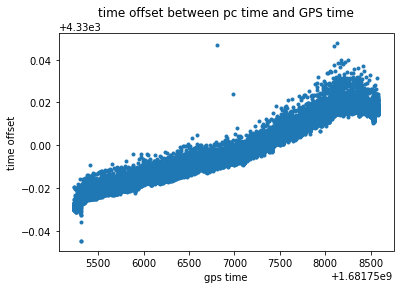

the sonar is 4329.99 seconds behind the GNSS timestamp


<Figure size 432x288 with 0 Axes>

In [22]:
#6.3
# now plot my time offset between GPS and sonar
pc_time_off = GPS['pc_time_gga'] + ET2UTC - GPS['gps_time']

# Compare GPS data to make sure timing is ok
plt.figure()
plt.plot(GPS['gps_time'], pc_time_off, '.')
plt.title('time offset between pc time and GPS time')
plt.xlabel('gps time')
plt.ylabel('time offset')
plt.show()
plt.savefig(os.path.join(plotDir, 'clockOffset.png'))
print(f'the sonar is {np.median(pc_time_off):.2f} seconds behind the GNSS timestamp')

In [23]:
# 6.4 Use the cerulean instantaneous bed detection since not sure about delay with smoothed
# adjust time of the sonar time stamp with timezone shift (ET -> UTC) and the timeshift between the computer and GPS
S1['time'] = S1['time'] + ET2UTC - np.median(pc_time_off)  # DT.timedelta(hours=5)  # convert to UTC
sonar_range = S1['smooth_depth_m'] # S1['this_ping_depth_m']
# use the above to adjust whether you want smoothed/filtered data or raw ping depth values

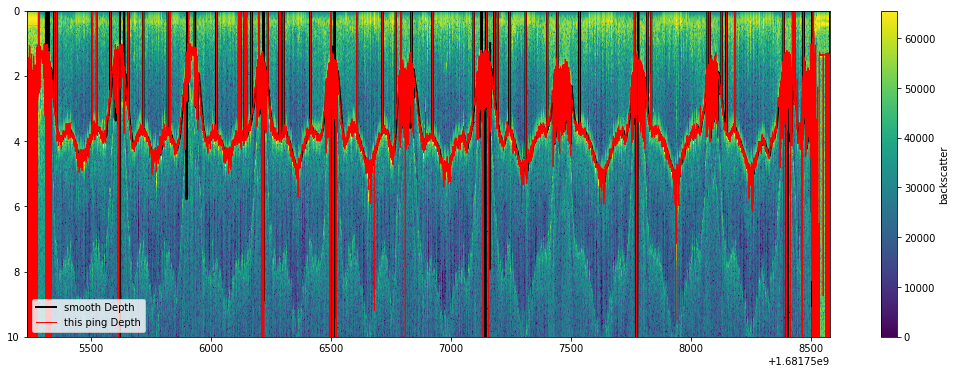

In [24]:
# 6.5 now plot sonar with time
plt.figure(figsize=(18,6))
cm = plt.pcolormesh(S1['time'], S1['range_m'], S1['profile_data'])
cbar = plt.colorbar(cm)
cbar.set_label('backscatter')
plt.plot(S1['time'], S1['smooth_depth_m'], 'k-', lw=2, label='smooth Depth')
plt.plot(S1['time'], S1['this_ping_depth_m'], 'r-', lw=1, label='this ping Depth')
plt.ylim([10, 0])
plt.legend(loc='lower left')
#plt.gca().invert_yaxis()
plt.savefig(os.path.join(plotDir, 'SonarBackScatter.png'))

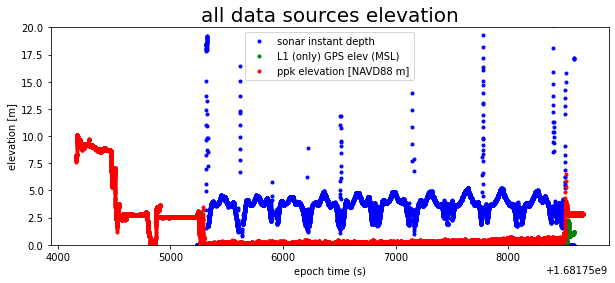

<Figure size 432x288 with 0 Axes>

In [25]:
# 6.6 Now lets take a look at all of our data from the different sources 
plt.figure(figsize=(10, 4))
plt.title('all data sources elevation', fontsize=20)
plt.plot(S1['time'], sonar_range, 'b.', label='sonar instant depth')
plt.plot(GPS['gps_time'], GPS['altMSL'], '.g', label='L1 (only) GPS elev (MSL)')
plt.plot(ppkGPS['epochTime'], ppkGPS['GNSS_elevation_NAVD88'], '.r', label='ppk elevation [NAVD88 m]')
plt.ylim([0, 20])
plt.ylabel('elevation [m]')
plt.xlabel('epoch time (s)')
plt.legend()
plt.show()
plt.savefig(os.path.join(plotDir, 'AllData.png'))
print('These data need to overlap!')

In [26]:
# 6.7 # plot sonar, select indices of interest, and then second subplot is time of interest
%matplotlib tk 

plt.figure(figsize=(10,4))
plt.subplot(211)
plt.title('all data, select start/end point for measured depths\nadd extra time for PPK offset')
plt.plot(sonar_range)
# plt.ylim([0,10])
d = plt.ginput(2)

plt.subplot(212)
# Now pull corresponding indices for sonar data for same time
sonarIndicies = np.arange(np.floor(d[0][0]).astype(int), np.ceil(d[1][0]).astype(int))
plt.plot(sonar_range[sonarIndicies])
plt.title('my selected data to proceed with')
plt.tight_layout()
# plt.ylim([0,10])
plt.savefig(os.path.join(plotDir, 'subsetForCrossCorrelation.png'))


# now identify corresponding times from ppk GPS to those times of sonar that we're interested in
indsPPK = np.where((ppkGPS['epochTime'] >= S1['time'][sonarIndicies[0]]) &
                   (ppkGPS['epochTime'] <= S1['time'][sonarIndicies[-1]]))[0]


In [27]:
# 6.7 interpolate and calculate the phase offset between the signals
from scipy import interpolate, signal
 
## now interpolate the lower sampled (sonar 3.33 hz) to the higher sampled data (gps 10 hz)
# identify common timestamp to interpolate to at higher frequency
commonTime = np.linspace(ppkGPS['epochTime'][indsPPK[0]], ppkGPS['epochTime'][indsPPK[-1]],
                        int((ppkGPS['epochTime'][indsPPK[-1]] - ppkGPS['epochTime'][indsPPK[0]])/.1), endpoint=True)

f = interpolate.interp1d(S1['time'], sonar_range) #, fill_value='extrapolate')
sonar_range_i = f(commonTime)
f = interpolate.interp1d(ppkGPS['epochTime'], ppkGPS['height'])
ppkHeight_i = f(commonTime)
# now i have both signals at the same time stamps
phaseLagInSamps, phaseLaginTime = findTimeShiftCrossCorr(signal.detrend(ppkHeight_i),
                                                                      signal.detrend(sonar_range_i),
                                                                      sampleFreq=np.median(np.diff(commonTime)))



## Now identify period with waves over close to flat bottom
plot should open up, use left mouse button to chose 2 points that start/finish a mostly flat portion of sensed depth.  Code will then detrend and cross-correlate the two signals (GNSS and sonar) to find a time offset between the two to do fine tuning of time adjustments. 

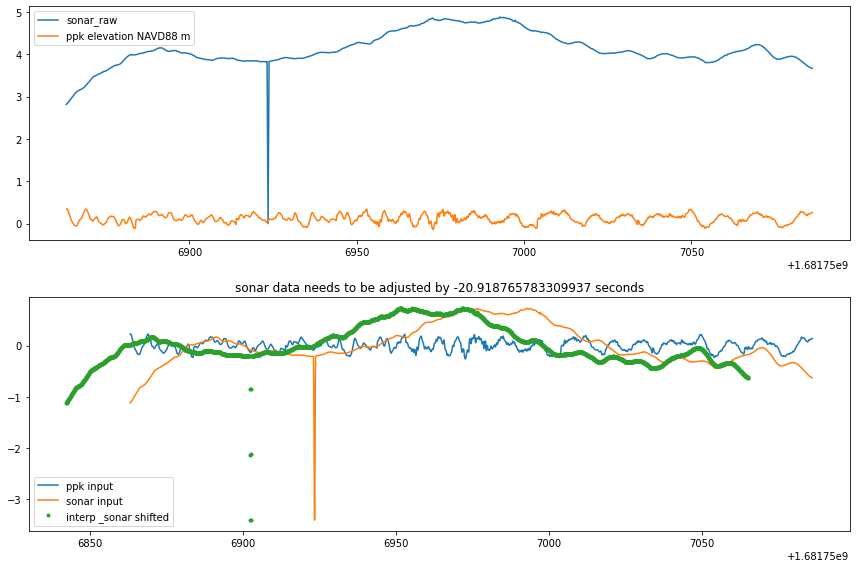

sonar data needs to be adjusted by -20.919 seconds


<Figure size 432x288 with 0 Axes>

In [28]:
# 6.8 show the subset signals and original input and shifted signal
%matplotlib inline
# now make figure where i have subset that only looks at sonar elevations and GPS elevations
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(S1['time'][sonarIndicies], sonar_range[sonarIndicies], label='sonar_raw')
plt.plot(ppkGPS['epochTime'][indsPPK], ppkGPS['GNSS_elevation_NAVD88'][indsPPK], label='ppk elevation NAVD88 m')
plt.legend()
plt.subplot(212)
plt.title(f"sonar data needs to be adjusted by {phaseLaginTime} seconds")
plt.plot(commonTime, signal.detrend(ppkHeight_i), label='ppk input')
plt.plot(commonTime, signal.detrend(sonar_range_i), label='sonar input')
plt.plot(commonTime+phaseLaginTime, signal.detrend(sonar_range_i), '.', label='interp _sonar shifted')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(plotDir, 'subsetAfterCrossCorrelation.png'))

print(f"sonar data needs to be adjusted by {phaseLaginTime:.3f} seconds")

Now we have our timeshift for the sonar data and we have this properly synced up with the ppk lat/lons.  let's work on combining and exporting these data to NAVD88 elevations.  Here we create a common time stamp to the 0.1 second which is the higher resolution of the 2 data sources (GNSS is 10hz, sonar is 3 hz).  

In [29]:
## now process all data for saving to file
antenna_offset = 0.25 # meters between the antenna phase center and sounder head
PPKqualityThreshold = 1
smoothedSonarConfidence = 60
sonar_time_out = S1['time'] + phaseLaginTime

## ok now put the sonar data on the GNSS timestamps which are decimal seconds.  We can do this with sonar_time_out,
# because we just adjusted by the phase lag to make sure they are timesynced.
timeOutInterpStart =  np.ceil(sonar_time_out.min() * 10)/10 # round to nearest 0.1
timeOutInterpEnd = np.floor(sonar_time_out.max() * 10)/10   # round to nearest 0.1
# create a timestamp for data to be output and in phase with that of the ppk gps data which are on the 0.1 s
time_out = np.linspace(timeOutInterpStart, timeOutInterpEnd, int((timeOutInterpEnd - timeOutInterpStart)/0.1),
                       endpoint=True)

print("here's where some better filtering could be done, probably worth saving an intermediate product here for future "
      "revisit")
print(f"for now we're only saving/logging values that have a GNSS fix quality of {PPKqualityThreshold} and a sonar confidence > {smoothedSonarConfidence}")

# now put relevant GNSS and sonar on output timestamps
#initalize out variables
sonar_smooth_depth_out, sonar_smooth_confidence_out = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan
sonar_instant_depth_out, sonar_instant_confidence_out  = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan
sonar_backscatter_out = np.zeros((time_out.shape[0], S1['range_m'].shape[0]))*np.nan
lat_out, lon_out = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan
elevation_out, fix_quality = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan


# loop through my common time (.1 s increment) and find associated sonar and gnss values
# this might be 
for tidx, tt in tqdm.tqdm(enumerate(time_out)):
    idxTimeMatchGNSS, idxTimeMatchGNSS = None, None
    
    #first find if theres a time match for sonar
    sonarlogic = np.abs(np.ceil(tt * 10)/10 - np.ceil(sonar_time_out*10)/10)
    if sonarlogic.min() <= 0.2: # 0.2  with a sampling of <0-2, it should identify the nearest sample (at 0.3s interval)
        idxTimeMatchSonar= np.argmin(sonarlogic)
    # then find comparable time match for ppk
    ppklogic = np.abs(np.ceil(tt * 10)/10 - np.ceil(ppkGPS['epochTime'].array*10)/10)
    if ppklogic.min() <= 0.101:  # .101 handles numerics
        idxTimeMatchGNSS = np.argmin(ppklogic)
    # if we have both, then we log the data
    if idxTimeMatchGNSS is not None and idxTimeMatchSonar is not None : # we have matching data
        if ppkGPS['Q'][idxTimeMatchGNSS] <= PPKqualityThreshold and S1['smoothed_depth_measurement_confidence'][idxTimeMatchSonar] > smoothedSonarConfidence:
            sonar_smooth_depth_out[tidx] = S1['smooth_depth_m'][idxTimeMatchSonar]
            sonar_instant_depth_out[tidx] = S1['this_ping_depth_m'][idxTimeMatchSonar]
            sonar_smooth_confidence_out[tidx] = S1['smoothed_depth_measurement_confidence'][idxTimeMatchSonar]
            sonar_instant_confidence_out[tidx] = S1['this_ping_depth_measurement_confidence'][idxTimeMatchSonar]
            sonar_backscatter_out[tidx] = S1['profile_data'][:, idxTimeMatchSonar]
            lat_out[tidx] = ppkGPS['lat'][idxTimeMatchGNSS]
            lon_out[tidx] = ppkGPS['lon'][idxTimeMatchGNSS]
            elevation_out[tidx] = ppkGPS['GNSS_elevation_NAVD88'][idxTimeMatchGNSS] - antenna_offset - S1['smooth_depth_m'][
                idxTimeMatchSonar]
            fix_quality[tidx] = ppkGPS['Q'][idxTimeMatchGNSS]

# identify data that are not nan's to save
idxDataToSave = np.argwhere(~np.isnan(sonar_smooth_depth_out)) # identify data that are not NaNs


here's where some better filtering could be done, probably worth saving an intermediate product here for future revisit
for now we're only saving/logging values that have a GNSS fix quality of 1 and a sonar confidence > 60


33488it [00:26, 1260.29it/s]


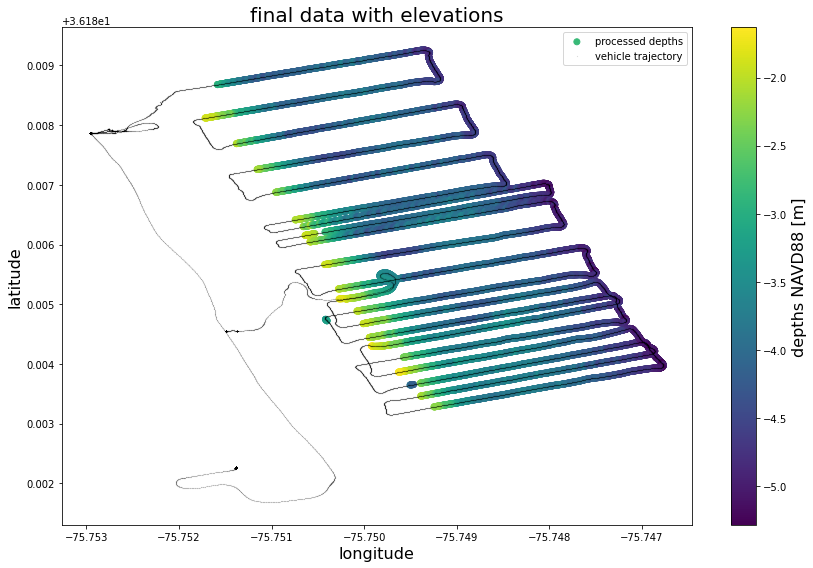

In [36]:
fs = 16
# make a final plot of all the processed data
plt.figure(figsize=(12,8))
plt.scatter(lon_out[idxDataToSave], lat_out[idxDataToSave], c=elevation_out[idxDataToSave], label='processed depths')
cbar = plt.colorbar()
cbar.set_label('depths NAVD88 [m]', fontsize=fs)
plt.plot(ppkGPS['lon'], ppkGPS['lat'], 'k.', ms=0.1, label='vehicle trajectory')
plt.ylabel('latitude', fontsize=fs)
plt.xlabel('longitude', fontsize=fs)
plt.title('final data with elevations', fontsize=fs+4)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plotDir, 'FinalDataProduct.png'))


outputfile = os.path.join(datadir,f'{timeString}_finalDataProduct.h5')
with h5py.File(outputfile, 'w') as hf:
    hf.create_dataset('time', data=time_out[idxDataToSave])
    hf.create_dataset('longitude', data=lon_out[idxDataToSave])
    hf.create_dataset('latitude', data=lat_out[idxDataToSave])
    hf.create_dataset('elevation', data=elevation_out[idxDataToSave])
    hf.create_dataset('fix_quality', data=fix_quality[idxDataToSave])
    hf.create_dataset('sonar_smooth_depth', data=sonar_smooth_depth_out[idxDataToSave])
    hf.create_dataset('sonar_smooth_confidence', data=sonar_smooth_confidence_out[idxDataToSave])
    hf.create_dataset('sonar_instant_depth', data=sonar_instant_depth_out[idxDataToSave])
    hf.create_dataset('sonar_instant_confidence', data=sonar_instant_confidence_out[idxDataToSave])
    hf.create_dataset('sonar_backscatter_out', data=sonar_backscatter_out[idxDataToSave])
